# Imports

In [ ]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose

import torchvision.models as models
from torchvision.models import vgg19
from torchvision.transforms import Normalize
from torch.cuda.amp import GradScaler, autocast
from numba import cuda

from skimage.metrics import structural_similarity as SSIM

from google.colab import drive

import matplotlib.pyplot as plt

import cv2
import numpy as np
import random
import shutil

# Generate directories and connect to drive

In [ ]:
data_dir = 'data'
weights_dir = 'data/weights'

os.makedirs(data_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Save only images with resolution of 2040 or higher to dataset

In [ ]:
# Function to filter images by resolution
def filter_images_by_resolution(image_files, min_width=2048, min_height=2048):
    filtered_images = []

    for image_file in image_files:
        with Image.open(image_file) as img:
            width, height = img.size
            if width >= min_width or height >= min_height:
                if img.mode == 'RGBA':  # Check if the image is in RGBA mode
                    img = img.convert('RGB')  # Convert to RGB mode

                filtered_images.append(image_file)

                # Save the filtered images to a new directory
                img.save(os.path.join(output_path, os.path.basename(image_file)))

    return filtered_images

In [ ]:
# Path to your dataset
dataset_path = '/content/drive/My Drive/example_set'

# Directory where you want to save the filtered images
output_path = '/content/drive/My Drive/filtered_set/HR'
os.makedirs(output_path, exist_ok=True)

# List all image files in the directory
image_files = [os.path.join(dataset_path, fname) for fname in os.listdir(dataset_path) if fname.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

In [ ]:
filtered_images = filter_images_by_resolution(image_files)

print(f"Found {len(filtered_images)} images with a width or height of 2K or higher.")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (143197800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Found 108 images with a width or height of 2K or higher.


# Generate Dataset with top high res images

In [ ]:
num_of_images = 1000

# Path to your dataset
dataset_path = '/content/drive/My Drive/example_set'

# List all image files in the directory
image_files = [os.path.join(dataset_path, fname) for fname in os.listdir(dataset_path) if fname.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]

# Create a list to hold image paths and their resolutions
image_resolutions = []

# Iterate over the images and get their resolutions
for image_file in image_files:
    with Image.open(image_file) as img:
        width, height = img.size
        resolution = width * height
        image_resolutions.append((image_file, resolution))

# Sort images by resolution in descending order
sorted_images = sorted(image_resolutions, key=lambda x: x[1], reverse=True)

# Select the top number of images accodring to num_of_images variable
top_images = sorted_images[:num_of_images]

# Extract the file paths of top images
top_image_paths = [image[0] for image in top_images]

# Print the selected top images (optional)
for img_path in top_image_paths:
    print(img_path)

/content/drive/My Drive/dataset_3000/c821b64e6daec7.jpg
/content/drive/My Drive/dataset_3000/39f6a534ee042e.jpg
/content/drive/My Drive/dataset_3000/b43c8a9e3e20d7.jpg
/content/drive/My Drive/dataset_3000/b674211963db81.jpg
/content/drive/My Drive/dataset_3000/3290a60563e77b.jpg
/content/drive/My Drive/dataset_3000/0b2b65b5081cb2.jpg
/content/drive/My Drive/dataset_3000/443393762dae1a.jpg
/content/drive/My Drive/dataset_3000/8150c716fb2ead.jpg
/content/drive/My Drive/dataset_3000/91dd2cfdc7905e.jpg
/content/drive/My Drive/dataset_3000/de6b454e2275a6.jpg
/content/drive/My Drive/dataset_3000/e96b7b585b8cb4.jpg
/content/drive/My Drive/dataset_3000/03a2f18225d6d5.jpg
/content/drive/My Drive/dataset_3000/03b5d7971087fc.jpg
/content/drive/My Drive/dataset_3000/3b756f05c3f805.jpg
/content/drive/My Drive/dataset_3000/f0746e7a2fe766.jpg
/content/drive/My Drive/dataset_3000/71da47f87affd7.jpg
/content/drive/My Drive/dataset_3000/2dde7623a6facb.jpg
/content/drive/My Drive/dataset_3000/3d8efc548c2

In [ ]:
# Directory to save the top images
output_dir = '/content/drive/My Drive/example_set/HR'
os.makedirs(output_dir, exist_ok=True)

for img_path in top_image_paths:
    shutil.copy(img_path, output_dir)

# Rotate Images

In [ ]:
def get_y_axis_rotation_matrix(w, h, angle):
    angle_rad = np.deg2rad(angle)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)

    # Calculate the new width after rotation
    new_w = w * cos_angle

    # Calculate the destination points for perspective transform
    src_points = np.float32([
        [0, 0],
        [w, 0],
        [w, h],
        [0, h]
    ])

    dst_points = np.float32([
        [(w - new_w) / 2, 0],
        [(w + new_w) / 2, 0],
        [(w + new_w) / 2, h],
        [(w - new_w) / 2, h]
    ])

    return cv2.getPerspectiveTransform(src_points, dst_points), (w, h)

def apply_y_axis_rotation(image, angle):
    h, w = image.shape[:2]
    M, new_size = get_y_axis_rotation_matrix(w, h, angle)
    transformed_image = cv2.warpPerspective(image, M, new_size, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    return transformed_image

def process_directory(input_dir, output_dir, num_angles=5, angle_range=(80, 89)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(input_dir, filename)
            image = cv2.imread(image_path)
            base_filename = os.path.splitext(filename)[0]

            for i in range(num_angles):
                angle = random.uniform(*angle_range)
                transformed_image = apply_y_axis_rotation(image, angle)
                output_filename = f"{base_filename}_rotated_{i+1}.jpg"
                output_path = os.path.join(output_dir, output_filename)
                cv2.imwrite(output_path, transformed_image)

In [ ]:
input_directory = '/content/drive/My Drive/example_set/HR'
output_directory = '/content/drive/My Drive/example_set/rotated/HR'

process_directory(input_directory, output_directory, num_angles=1, angle_range=(40, 70)) # Change the angle according to your desired rotation.

# Downsample HR images into LR

In [ ]:
def downsample_image(image_path, output_path, scale_factor=4):
    with Image.open(image_path) as img:
        # Convert RGBA to RGB if necessary
        if img.mode == 'RGBA' or img.mode == 'P':
            img = img.convert('RGB')
        lr_img = img.resize((img.width // scale_factor, img.height // scale_factor), Image.BICUBIC)
        lr_img.save(output_path, 'JPEG')

In [ ]:
hr_folder = '/content/drive/My Drive/example_set/HR'
lr_folder = '/content/drive/My Drive/example_set/LR'
os.makedirs(lr_folder, exist_ok=True)

# Downsample HR images to create LR images
count = 1
for filename in os.listdir(hr_folder):
    if (count % 50 == 0): # Print the number of batch and image file name every 50 images.
      print(count, filename)
    count+=1
    if filename.endswith(".png") or filename.endswith(".jpg"):
        hr_image_path = os.path.join(hr_folder, filename)
        lr_image_path = os.path.join(lr_folder, filename)
        downsample_image(hr_image_path, lr_image_path, scale_factor=4)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (143197800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


50 21b289f973e1cd_rotated_1.jpg
100 a71c3fe1836a0b_rotated_1.jpg


# SR Generator (GSR)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        return x + self.conv2(self.prelu(self.conv1(x)))

class GSR(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residuals=5):
        super(GSR, self).__init__()
        self.encoder = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        self.resnet = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residuals)])
        self.decoder = nn.Conv2d(64, out_channels, kernel_size=5, padding=2)
        self.upsample = nn.Upsample(scale_factor=4, mode='bicubic')

    def forward(self, x):
        x = self.upsample(x)
        x = self.encoder(x)
        x = self.resnet(x)
        x = self.decoder(x)
        return torch.clamp(x, 0, 1)

# Discriminators (Dx and Dy)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
             self._block(64, 128, 3, 1),
             self._block(128, 256, 3, 1),
             self._block(256, 512, 3, 1),
            nn.Conv2d(512, 1, kernel_size=3, padding=1)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x)

# LR Generator (GLR)

In [ ]:
class GLR(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GLR, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
             self._block(64, 128, 3, 2),
             self._block(128, 256, 3, 2),
            nn.Conv2d(256, out_channels, kernel_size=3, padding=1)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x)

# Loss Functions

In [ ]:
class SRResCycGANLosses:
    def __init__(self, vgg):
        self.vgg = vgg
        self.l1_loss = nn.L1Loss()
        self.tv_loss = TVLoss()

    def perceptual_loss(self, sr, hr):
        sr_vgg = self.vgg((sr - vgg_mean.to(sr.device)) / vgg_std.to(sr.device))
        hr_vgg = self.vgg((hr - vgg_mean.to(hr.device)) / vgg_std.to(hr.device))
        return self.l1_loss(sr_vgg, hr_vgg)

    def gan_loss(self, sr_pred, hr_pred):
        return F.binary_cross_entropy_with_logits(sr_pred, torch.ones_like(sr_pred)) + \
               F.binary_cross_entropy_with_logits(hr_pred, torch.zeros_like(hr_pred))

    def total_variation_loss(self, sr):
        return self.tv_loss(sr)

    def content_loss(self, sr, hr):
        return self.l1_loss(sr, hr)

    def cyclic_loss(self, lr_recon, lr):
        return self.l1_loss(lr_recon, lr)

    def total_loss(self, sr, hr, lr_recon, lr, sr_pred, hr_pred):
        # Resize tensors to ensure shape compatibility
        hr_resized = F.interpolate(hr, size=sr.size()[2:], mode='bicubic', align_corners=False)
        lr_resized = F.interpolate(lr, size=lr_recon.size()[2:], mode='bicubic', align_corners=False)

        l_per = self.perceptual_loss(sr, hr_resized)
        l_gan = self.gan_loss(sr_pred, hr_pred)
        l_tv = self.total_variation_loss(sr)
        l_content = self.content_loss(sr, hr_resized)
        l_cyclic = self.cyclic_loss(lr_recon, lr_resized)

        return l_per + l_gan + l_tv + 10 * l_content + 10 * l_cyclic

In [ ]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:, :, 1:, :])
        count_w = self._tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    def _tensor_size(self, t):
        return t.size()[1] * t.size()[2] * t.size()[3]

# Training the Model

In [ ]:
# A function to save the weights for a desired epoch.
def save_weights(generator_sr, generator_lr, discriminator_sr, discriminator_lr, epoch):
    save_num = epoch + 1
    sr_g_file_name = f"data/weights/generator_sr_epoch_{save_num}.pth"
    lr_g_file_name = f"data/weights/generator_lr_epoch_{save_num}.pth"
    sr_d_file_name = f"data/weights/discriminator_sr_epoch_{save_num}.pth"
    lr_d_file_name = f"data/weights/discriminator_lr_epoch_{save_num}.pth"
    torch.save(generator_sr.state_dict(), sr_g_file_name)
    torch.save(generator_lr.state_dict(), lr_g_file_name)
    torch.save(discriminator_sr.state_dict(), sr_d_file_name)
    torch.save(discriminator_lr.state_dict(), lr_d_file_name)

In [ ]:
# A function to save only generator weights for a desired epoch. (Used when only training generator)
def save_generator_weights(generator_sr, generator_lr, epoch):
    save_num = epoch + 1
    sr_g_file_name = f"data/weights/generator_sr_epoch_{save_num}.pth"
    lr_g_file_name = f"data/weights/generator_lr_epoch_{save_num}.pth"
    torch.save(generator_sr.state_dict(), sr_g_file_name)
    torch.save(generator_lr.state_dict(), lr_g_file_name)

In [ ]:
# Training loop
def train_srrescycgan(generator_sr, generator_lr, discriminator_hr, discriminator_lr, data_loader, optimizer_g, optimizer_d, losses, num_epochs):
    # Initialize scaler
    scaler = GradScaler()

    g_history = [0] * num_epochs
    d_history = [0] * num_epochs

    # scheduler_g = StepLR(optimizer_g, step_size=5, gamma=0.5) # To use changing learning rate uncomment these two lines and set them according to your requirements.
    # scheduler_d = StepLR(optimizer_g, step_size=5, gamma=0.5) # scheduler_g is for generator, scheduler_d is for discriminator.
    for epoch in range(num_epochs):
        count = 0
        for i, (lr, hr) in enumerate(data_loader):
            lr, hr = lr.to(device), hr.to(device)
            count = count + 1
            if (count % 50 == 0): # Print the number of batches passed every 50 batches.
              print('Batch Number:', count)

            # Train Generators
            optimizer_g.zero_grad()
            with autocast():
                sr = generator_sr(lr)
                lr_recon = generator_lr(sr)
                sr_pred = discriminator_hr(sr)
                hr_pred = discriminator_hr(hr)

                loss_g = losses.total_loss(sr, hr, lr_recon, lr, sr_pred, hr_pred)

            scaler.scale(loss_g).backward()
            scaler.step(optimizer_g)
            scaler.update()

            # Train Discriminators
            optimizer_d.zero_grad()
            with autocast():
                sr_pred = discriminator_hr(sr.detach())
                hr_pred = discriminator_hr(hr)
                loss_d_hr = losses.gan_loss(sr_pred, hr_pred)

                lr_pred = discriminator_lr(lr_recon.detach())
                lr_real_pred = discriminator_lr(lr)

                loss_d_lr = losses.gan_loss(lr_pred, lr_real_pred)

                loss_d = loss_d_hr + loss_d_lr

            scaler.scale(loss_d).backward()
            scaler.step(optimizer_d)
            scaler.update()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item()}, Loss D: {loss_d.item()}")
        save_weights(generator_sr, generator_lr, discriminator_hr, discriminator_lr, epoch) # Save the weights each epoch (can be changed with an if statement).
        g_history[epoch] = loss_g.item() # Save generator loss for later plotting.
        d_history[epoch] = loss_d.item() # Save discriminator loss for later plotting.

        # scheduler_g.step()
        # scheduler_d.step()

    return g_history, d_history

# Train Generator Only

In [ ]:
# Training loop only for generator
def train_generator_only(generator_sr, generator_lr, discriminator_hr, data_loader, optimizer_g, losses, num_epochs):
    scaler = GradScaler()
    g_history = [0] * num_epochs

    # scheduler_g = StepLR(optimizer_g, step_size=10, gamma=0.5) # To use changing learning rate uncomment this line and set them according to your requirements.

    for epoch in range(num_epochs):
        count = 0
        for i, (lr, hr) in enumerate(data_loader):
            lr, hr = lr.to(device), hr.to(device)
            count = count + 1
            if (count % 50 == 0): # Print the batch number every 50 batches.
                print('Batch Number:', count)

            # Train Generator
            optimizer_g.zero_grad()
            with autocast():
                sr = generator_sr(lr)
                lr_recon = generator_lr(sr)
                sr_pred = discriminator_hr(sr)
                hr_pred = discriminator_hr(hr)


                loss_g = losses.total_loss(sr, hr, lr_recon, lr, sr_pred, hr_pred)

            scaler.scale(loss_g).backward()
            scaler.step(optimizer_g)
            scaler.update()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item()}")
        save_generator_weights(generator_sr, generator_lr, epoch)
        g_history[epoch] = loss_g.item() # Save the generator's loss for later plotting.

        scheduler_g.step()

    return g_history

# Load Dataset

In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted([file for file in os.listdir(lr_dir) if file.endswith(('.png', '.jpg', '.jpeg'))])
        self.hr_images = sorted([file for file in os.listdir(hr_dir) if file.endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.hr_images[idx])

        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [ ]:
# Paths
lr_dir = '/content/drive/My Drive/example_set/LR'
hr_dir = '/content/drive/My Drive/example_set/HR'

# Define a transform to resize images to 256x256 and convert to tensor
transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

dataset = SRDataset(lr_dir, hr_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=3, num_workers=4, shuffle=True, pin_memory=True) # Build Batches

# Print chapes of each low resolution and high resolution image (optional)
for lr, hr in data_loader:
    print(lr.shape, hr.shape)

torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256]) torch.Size([3, 3, 256, 256])
torch.Size([3,

# Add VGG19

In [ ]:
# VGG19 model for perceptual loss
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        vgg = models.vgg19(pretrained=True)
        self.features = nn.Sequential(*list(vgg.features.children())[:36]).eval()  # Use first 36 layers

        # Freeze parameters
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.features(x)

In [ ]:
# Normalize input images for VGG19
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Run Training

In [ ]:
# Model, Optimizer, and Losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_sr = GSR().to(device)
generator_lr = GLR().to(device)
discriminator_hr = Discriminator().to(device)
discriminator_lr = Discriminator().to(device)
vgg = VGG19().to(device)
optimizer_g = torch.optim.Adam(list(generator_sr.parameters()) + list(generator_lr.parameters()), lr=0.00001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
optimizer_d = torch.optim.Adam(list(discriminator_hr.parameters()) + list(discriminator_lr.parameters()), lr=0.00001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
losses = SRResCycGANLosses(vgg=vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 219MB/s]


# Load pretrained net weights (Optional)

In [ ]:
# If the training starts from scratch and no weights are loaded, comment these lines.
generator_sr.load_state_dict(torch.load('generator_sr.pth'))
generator_lr.load_state_dict(torch.load('generator_lr.pth'))

discriminator_hr.load_state_dict(torch.load('discriminator_hr.pth'))
discriminator_lr.load_state_dict(torch.load('discriminator_lr.pth'))

optimizer_g.load_state_dict(torch.load('optimizer_g.pth'))
optimizer_d.load_state_dict(torch.load('optimizer_d.pth'))

# Freeze layers for fine tuning process (Optional)

In [ ]:
def freeze_layers(model, num_layers_to_train=2):
    layers = list(model.children())
    num_layers = len(layers)

    # Freeze all layers except the last num_layers_to_train layers
    for i, layer in enumerate(layers[:-num_layers_to_train]):
        for param in layer.parameters():
            param.requires_grad = False

In [ ]:
# Freeze all layers except the last two in the generator
freeze_layers(generator_sr, num_layers_to_train=2)
freeze_layers(generator_lr, num_layers_to_train=2)

In [ ]:
optimizer_g = torch.optim.Adam(filter(lambda p: p.requires_grad, generator_sr.parameters()), lr=0.00001)

# Run training loop only for the generator

In [ ]:
g_history = train_generator_only(generator_sr, generator_lr, discriminator_hr, data_loader, optimizer_g, losses, num_epochs=30)

Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [1/30], Loss G: 3.205277442932129
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [2/30], Loss G: 2.2835164070129395
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [3/30], Loss G: 2.876070261001587
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [4/30], Loss G: 2.332935094833374
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [5/30], Loss G: 2.9227826595306396
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [6/30], Loss G: 3.4442355632781982
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [7/30], Loss G: 3.5167489051818848
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoc

# Run Training loop for both generator and discriminator

In [ ]:
g_history, d_history = train_srrescycgan(generator_sr, generator_lr, discriminator_hr, discriminator_lr, data_loader, optimizer_g, optimizer_d, losses, num_epochs=30)

Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [1/30], Loss G: 4.399223327636719, Loss D: 1.9135010242462158
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [2/30], Loss G: 2.634148120880127, Loss D: 1.3325233459472656
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [3/30], Loss G: 3.1390066146850586, Loss D: 0.8001880645751953
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [4/30], Loss G: 3.3095035552978516, Loss D: 0.5208702087402344
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [5/30], Loss G: 2.445537567138672, Loss D: 0.43163853883743286
Batch Number: 50
Batch Number: 100
Batch Number: 150
Batch Number: 200
Batch Number: 250
Epoch [6/30], Loss G: 1.2096621990203857, Loss D: 0.43497204780578613
Batch Number: 50
Batch Number: 100
Batch Number: 150


In [ ]:
# A function to plot the loss graph for discriminator/generator
def plot_losses(g_or_d, history):
  epochs = range(1, len(history) + 1)

  # Plot the loss vs. epoch
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, history, 'b-', marker='o', label=f'Loss {g_or_d}')  # 'b-' means blue line
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training Loss vs. Epoch {g_or_d}')
  plt.legend()
  plt.grid(True)
  plt.xticks(range(1, len(history) + 1))
  #plt.ylim(0, 0.01)
  plt.savefig(f'loss_vs_epoch_{g_or_d}.png')
  plt.show()

In [ ]:
# A function to plot both discriminator and generator losses in a single graph
def plot_losses_vs(g_history, d_history):
  epochs = range(1, len(g_history) + 1)

  # Plot the loss vs. epoch
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, g_history, 'b-', marker='o', label=f'Loss Generator')
  plt.plot(epochs, d_history, 'r-', marker='o', label=f'Loss Discriminator')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss vs. Epoch')
  plt.legend()
  plt.grid(True)
  plt.xticks(range(1, len(g_history) + 1))
  plt.savefig('loss_vs_epoch.png')
  plt.show()

# Plot discriminator loss graph

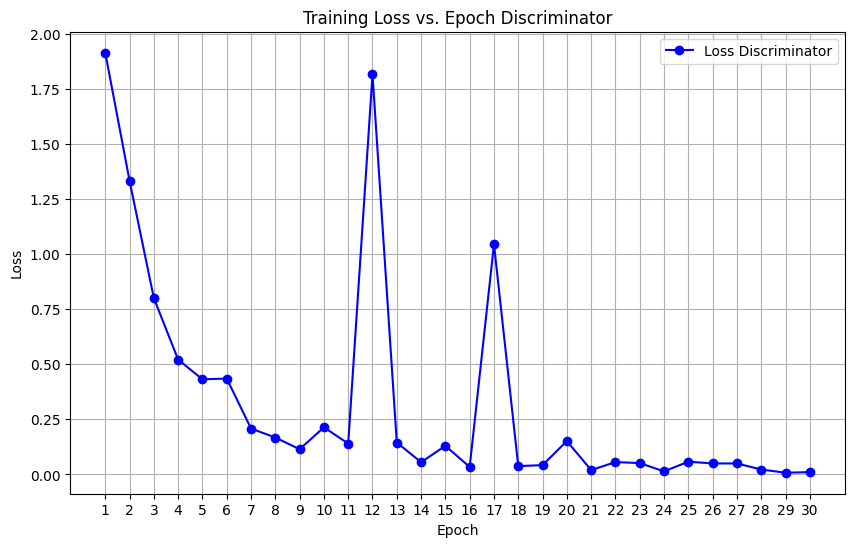

In [ ]:
plot_losses('Discriminator', d_history)

# Plot generator loss graph

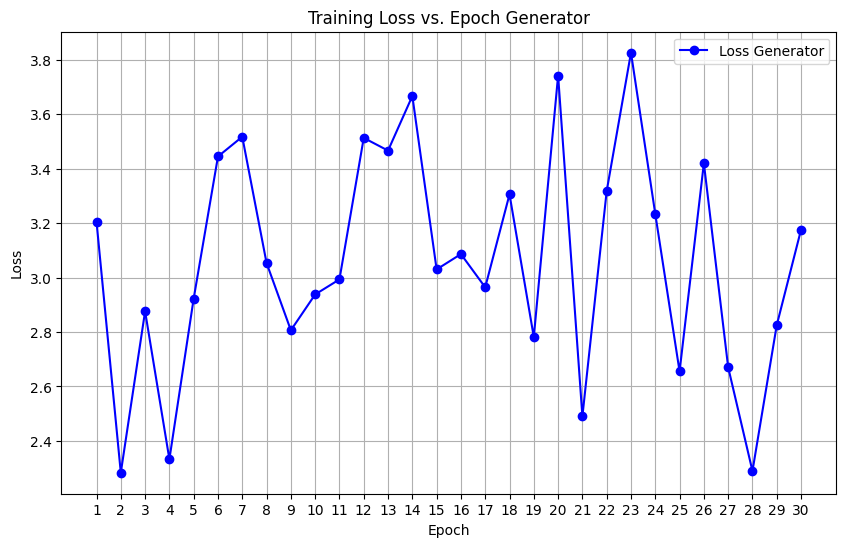

In [ ]:
plot_losses('Generator', g_history)

# Plot discriminator vs generator losses graph (optional)

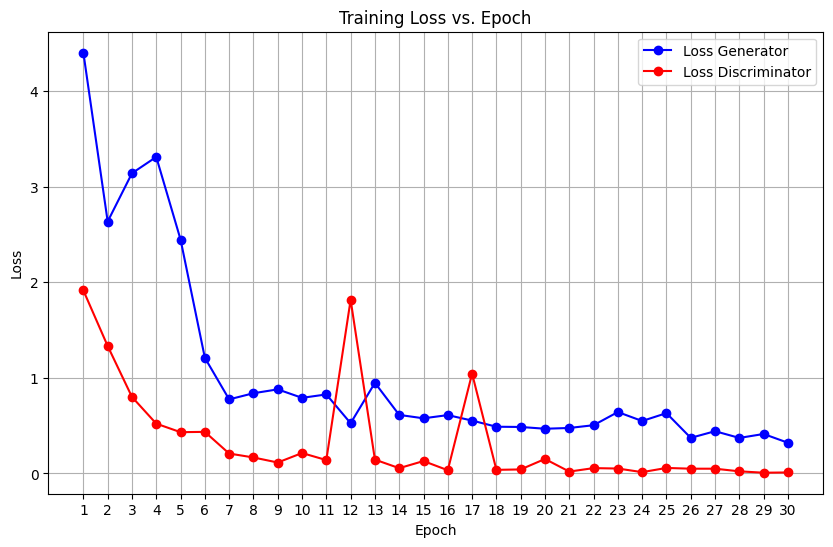

In [ ]:
# If only generator was trained there is no d_history. In this case use only plot generator loss graph.
plot_losses_vs(g_history, d_history)

# Save model weights (Optional)

In [ ]:
# If you decided to remove the save for each epoch in the training loop, this can be used to save all the model's components weights.
# Save the generator and discriminator weights
torch.save(generator_sr.state_dict(), 'data/weights/generator_sr.pth')
torch.save(generator_lr.state_dict(), 'data/weights/generator_lr.pth')
torch.save(discriminator_hr.state_dict(), 'data/weights/discriminator_hr.pth')
torch.save(discriminator_lr.state_dict(), 'data/weights/discriminator_lr.pth')

# Optionally, save the optimizer states as well
torch.save(optimizer_g.state_dict(), 'data/weights/optimizer_g.pth')
torch.save(optimizer_d.state_dict(), 'data/weights/optimizer_d.pth')

# Empty cuda cache and reset device (optional)

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# device = cuda.get_current_device()
# device.reset()